In [241]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')
%matplotlib inline

### About the dataset   

The dataset extracted and is publicly available from the UCI Machine Learning Repository (Asuncion and Newman, 2007)[http://mlearn.ics.uci.edu/MLRepository.html], consists of several hundred human cell sample records, each of which contains the values of a set of cell characteristics. The fields in each record are:

|Field name|Description|
|--- |--- |
|ID|Clump thickness|
|Clump|Clump thickness|
|UnifSize|Uniformity of cell size|
|UnifShape|Uniformity of cell shape|
|MargAdh|Marginal adhesion|
|SingEpiSize|Single epithelial cell size|
|BareNuc|Bare nuclei|
|BlandChrom|Bland chromatin|
|NormNucl|Normal nucleoli|
|Mit|Mitoses|
|Class|Benign or malignant|  

*The Class field contains the diagnosis, as confirmed by separate medical procedures, as to whether the samples are benign (value = 2) or malignant (value = 4)*   


**The objective is to build a machine learning algorithm (in this case a SVM) to accuratly predict wether a tumor is benign(2) or malignant(4). The aim of the model is to have a high recall rate (probabilty of detection)**

In [242]:
# csv url to be imported
csv_url = 'https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cell_samples.csv'

# dataframe
df = pd.read_csv(csv_url)
df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


## Ensure data is clean 

In [243]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
ID             699 non-null int64
Clump          699 non-null int64
UnifSize       699 non-null int64
UnifShape      699 non-null int64
MargAdh        699 non-null int64
SingEpiSize    699 non-null int64
BareNuc        699 non-null object
BlandChrom     699 non-null int64
NormNucl       699 non-null int64
Mit            699 non-null int64
Class          699 non-null int64
dtypes: int64(10), object(1)
memory usage: 60.1+ KB


In [268]:
# ensuring there are no missing values
df.isnull().sum()

ID             0
Clump          0
UnifSize       0
UnifShape      0
MargAdh        0
SingEpiSize    0
BareNuc        0
BlandChrom     0
NormNucl       0
Mit            0
Class          0
dtype: int64

In [269]:
# data types of dataset
df.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int64
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

In [270]:
# 'BareNuc' should be converted to an int data type
df = df[pd.to_numeric(df['BareNuc'], errors='coerce').notnull()]
df['BareNuc'] = df['BareNuc'].astype('int')
df['BareNuc'].dtypes

dtype('int64')

## Analyse data

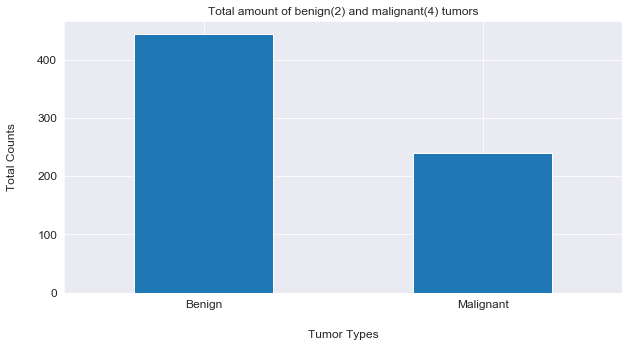

2    0.650073
4    0.349927
Name: Class, dtype: float64


In [279]:
fig, ax1 = plt.subplots(figsize=(10,5))
# plotting bar graph using pandas
df['Class'].value_counts().plot(kind='bar',
                               title='Total amount of benign(2) and malignant(4) tumors',
                               fontsize=12);

# labels on x axis
plt.xlabel('Tumor Types', 
           fontsize=12, 
           labelpad=20)
# labels on y axis
plt.ylabel("Total Counts", 
           fontsize=12, 
           labelpad=20)
# changing values of xticks
ax1.set_xticklabels(['Benign', 'Malignant'], 
                    rotation=0)
plt.show()

print(df['Class'].value_counts(normalize=True))

*From the bar plot aove we can see that malignant tumors have a high presence in the dataset at 34.99%*

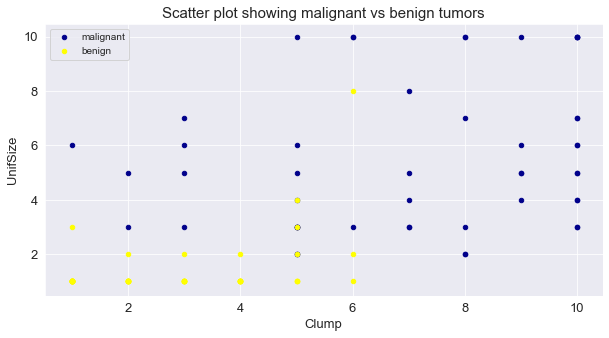

In [280]:
# plotting malignant tumors with darkblue
ax1 = df[df['Class'] == 4][0:50].plot(kind='scatter',
                                      x='Clump',
                                      y='UnifSize',
                                      color='DarkBlue', 
                                      label='malignant',
                                      figsize=(10,5),
                                      fontsize=13);
# plotting benign tumors with yellow
df[df['Class'] == 2][0:50].plot(kind='scatter',
                                x='Clump',
                                y='UnifSize',
                                color='Yellow', 
                                label='benign', 
                                ax=ax1);
plt.title('Scatter plot showing malignant vs benign tumors', fontsize=15)
plt.xlabel('Clump', fontsize=13)
plt.ylabel('UnifSize', fontsize=13)
plt.show()

In [281]:
df.corr()['Class'].sort_values()

ID            -0.084701
Mit            0.423448
SingEpiSize    0.690958
MargAdh        0.706294
Clump          0.714790
NormNucl       0.718677
BlandChrom     0.758228
UnifSize       0.820801
UnifShape      0.821891
BareNuc        0.822696
Class          1.000000
Name: Class, dtype: float64

# Feature Selection and Building ML Model

In [282]:
X = df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
y = df['Class']

In [283]:
# importing necessary models to create ML model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

# importing evaluation metrics
from sklearn.metrics import recall_score, roc_auc_score, classification_report, f1_score, confusion_matrix

In [284]:
# splitting data into training and testing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(546, 9) (546,)
(137, 9) (137,)


In [285]:
# for the best results using a SVM classifier, data should be normalized for best results
# creating scale object 
scale = MinMaxScaler()
# fit and transforms on training data
x_train_scaled = scale.fit_transform(x_train)
# transforming testing data
x_test_scaled = scale.transform(x_test)

In [286]:
# find the optimal kernel
kernels = ['linear', 'rbf', 'poly', 'sigmoid']

for k in kernels:
    clf = SVC(kernel=k, gamma=1.0).fit(x_train_scaled, y_train)
    yhat = clf.predict(x_test_scaled)
    score = clf.score(x_test_scaled, y_test)
    print('Kernel: ', k,
          '\nScore: ', score)

Kernel:  linear 
Score:  0.9562043795620438
Kernel:  rbf 
Score:  0.9635036496350365
Kernel:  poly 
Score:  0.9635036496350365
Kernel:  sigmoid 
Score:  0.7226277372262774


In [287]:
# from the above, the radial basis function kernel performs best
# now find optimal parameters
scores = []
n=1
for g in [0.01, 0.1, 1, 5]:
    for cs in [0.01, 0.1, 1, 5]:
        
        clf = SVC(kernel='rbf', gamma=g, C=cs).fit(x_train_scaled, y_train)
        yhat = clf.predict(x_test_scaled)
        scores.append(clf.score(x_test_scaled, y_test))
        print(n, '- Gamma: ', g, 
             ' C: ', cs)
        n+=1

1 - Gamma:  0.01  C:  0.01
2 - Gamma:  0.01  C:  0.1
3 - Gamma:  0.01  C:  1
4 - Gamma:  0.01  C:  5
5 - Gamma:  0.1  C:  0.01
6 - Gamma:  0.1  C:  0.1
7 - Gamma:  0.1  C:  1
8 - Gamma:  0.1  C:  5
9 - Gamma:  1  C:  0.01
10 - Gamma:  1  C:  0.1
11 - Gamma:  1  C:  1
12 - Gamma:  1  C:  5
13 - Gamma:  5  C:  0.01
14 - Gamma:  5  C:  0.1
15 - Gamma:  5  C:  1
16 - Gamma:  5  C:  5


In [288]:
print(scores)
# this will show between 1-9 from the values printed above
scores_max_pos = np.array(scores).argmax() + 1
scores_max_pos

[0.635036496350365, 0.708029197080292, 0.9343065693430657, 0.9416058394160584, 0.635036496350365, 0.9416058394160584, 0.9562043795620438, 0.9562043795620438, 0.9416058394160584, 0.9635036496350365, 0.9635036496350365, 0.9708029197080292, 0.635036496350365, 0.9416058394160584, 0.9635036496350365, 0.9708029197080292]


12

At number twelve, the best parameters would be Gamma=1, and C=5

## Building the final model  

              precision    recall  f1-score   support

      Benign       0.98      0.95      0.97        87
   Malignant       0.92      0.96      0.94        50

    accuracy                           0.96       137
   macro avg       0.95      0.96      0.95       137
weighted avg       0.96      0.96      0.96       137

F1 score of:  0.9709194151264308
Models Accuracy:  0.9562043795620438
Classification Error:  0.04379562043795615


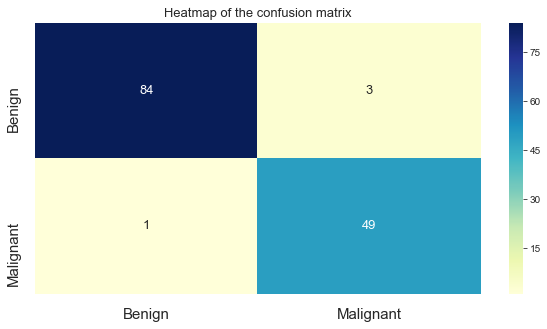

In [317]:
# best parameters that optimize the model are at gamma=1, C=5

# Build model
clf_final = SVC(kernel='rbf', gamma=1.0, C=5).fit(x_train_scaled, y_train)
# predictions
yhat = clf_final.predict(x_test_scaled)

# score of final model
acc_final = clf.score(x_test_scaled, y_test)
# f1 score using weighted average
f1_final = f1_score(y_test, yhat, average='weighted')

# classification report
report_final = classification_report(y_test, yhat, target_names=['Benign', 'Malignant'])
print(report)

# confusion matrix of results
matrix_final = confusion_matrix(y_test, yhat)

# plotting heatmap using the matrix
fig, ax1 = plt.subplots(figsize=(10,5))

heat_df = sns.heatmap(pd.DataFrame(matrix_final), 
                      xticklabels=['Benign', 'Malignant'],
                      annot=True, 
                      cmap="YlGnBu", 
                      fmt='.2g',
                      yticklabels=['Benign', 'Malignant'],
                      annot_kws={"size":13},
                      ax=ax1)
# showing heatmap
heat_df;
plt.title('Heatmap of the confusion matrix', fontsize=13)
ax1.tick_params(labelsize=15, pad=10)

print('F1 score of: ', f1_final)
print('Models Accuracy: ', acc_final)
print('Classification Error: ', 1-acc_final)

## Conclusion and Findings   

The model has a high recall rate of 98% mean that it has a high probability of detecting a cancerous tumor!  
The model also has a high accuracy of 97.08% and a low classification error of only 2.91%. Overall the accuracy and recall of model has performed optimally. However, a gridseacrh may be used to optimize it even more, which will be shown below.

### Using GridSearchCV to find optimum parameters

In [293]:
# parameters for gridsearch
grid_params = {'gamma': [0.01, 0.1, 1, 5], 
              'C': [0.01, 0.1, 1, 5]}

# svm model with radial basis kernel
clf = SVC(kernel='rbf')

# gridsearchcv object
grid_clf = GridSearchCV(clf, param_grid=grid_params, cv=5)
# fitting grid object
grid_clf.fit(x_train_scaled, y_train)

# best parameters found by GridSearchCV
best_parameters = grid_clf.best_params_
grids_score = grid_clf.score(x_test_scaled, y_test)

print('Best Parameters: ', best_parameters)
print('Best Score: ', grids_score)

Best Parameters:  {'C': 1, 'gamma': 0.1}
Best Score:  0.9562043795620438


              precision    recall  f1-score   support

      Benign       0.98      0.95      0.97        87
   Malignant       0.92      0.96      0.94        50

    accuracy                           0.96       137
   macro avg       0.95      0.96      0.95       137
weighted avg       0.96      0.96      0.96       137

F1 score of:  0.9563791226896461
Models Accuracy:  0.9562043795620438
Classification Error:  0.04379562043795615


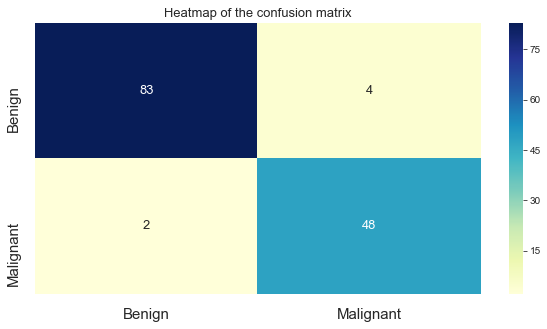

In [318]:
# build final model using gamma=0.1 and C=1
clf = SVC(kernel='linear', gamma=0.1, C=1).fit(x_train_scaled, y_train)
yhat = clf.predict(x_test_scaled)

# accuracy
acc_grid = clf.score(x_test_scaled, y_test)
# f1 score
f1_grid = f1_score(y_test, yhat, average='weighted')

# classification report
report = classification_report(y_test, yhat, target_names=['Benign', 'Malignant'])
print(report)

# matrix of results
matrix = confusion_matrix(y_test, yhat)

# plotting heatmap using the matrix
fig, ax1 = plt.subplots(figsize=(10,5))

# creating heatmap
heat_df = sns.heatmap(pd.DataFrame(matrix), 
                      xticklabels=['Benign', 'Malignant'],
                      annot=True, 
                      cmap="YlGnBu", 
                      fmt='.2g',
                      annot_kws={'size': 13},
                      yticklabels=['Benign', 'Malignant'],
                      ax=ax1)
# showing heatmap
heat_df;
plt.title('Heatmap of the confusion matrix', fontsize=13)
ax1.tick_params(labelsize=15, pad=10)

print('F1 score of: ', f1_grid)
print('Models Accuracy: ', acc_grid)
print('Classification Error: ', 1-acc_grid)

In [319]:
# Evaluation on gridseacrh vs manual searching
print('SVM Model Accuracy: ', round(acc_final * 100, 2), '%')
print('GridSearchCV Accuracy: ', round(acc_grid * 100, 2), '%')
print('\nSVM Model recall score: ', '98%')
print('GridSearchCV recall score: ', '96%')
print('\nSVM Model f1 score: ', round(f1_final * 100, 2), '%')
print('GridSearchCV f1 score: ', round(f1_grid * 100, 2), '%')
print('\nSVM Classification Error: ', round((1-acc_final) * 100, 2), '%')
print('GridSearchCV Classification Error: ', round((1-acc_grid) * 100, 2), '%')

SVM Model Accuracy:  95.62 %
GridSearchCV Accuracy:  95.62 %

SVM Model recall score:  98%
GridSearchCV recall score:  96%

SVM Model f1 score:  97.09 %
GridSearchCV f1 score:  95.64 %

SVM Classification Error:  4.38 %
GridSearchCV Classification Error:  4.38 %


# Final Conclusion on GridSearch and SVM   

From the above analysis, the GridSearchCV underperformed. The initial SVM model had a higher recall rate of 98% as opposed to the gridsearch of 96%. The classification error with the initial model is lower than the gridearch, indicating that our model is more accurate in predicting the correct class. It also outperformed in terms of the f1 score.

To increase the recall rate further, a different algorithm can be used such as a LogisticRegression or KNN. 

The optimum model found here is a Kernalized support vector machine (SVM). The kernel used is a radial basis function kernel (rbf) with a gamma value of 1.0 and C of 5.